# Gaussian-Hermite Reconstruction

In [16]:
import cv2
import numpy as np
import scipy as sp
import scipy.special
import scipy.misc
import math
import matplotlib.pyplot as plt
from scipy.special import factorial

In [17]:
fp = 'Zhang.png'
img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)

print(img.ravel()[np.flatnonzero(img)])
# img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# # img_gray = img_gray[10:85,10:85]
# print(np.flatnonzero(img_gray))
# print(img_gray.shape)
# print(img_gray)
# plt.imshow(img_gray,'gray_r')
# plt.show()

[ 64 255 255 ...  64 255 255]


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


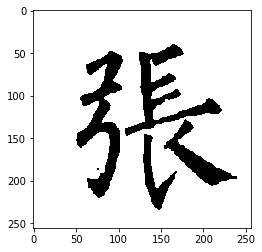

In [18]:
filepath = 'Zhang.png'
img_gray = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

ret, img_binary = cv2.threshold(img_gray, 127, 1, cv2.THRESH_BINARY_INV)
print(img_binary)
plt.imshow(img_binary,'gray')
plt.show()

In [19]:
print(img_gray.dtype.name)

uint8


In [20]:
def i_to_x(i):
    global k
    return (2*i-k+1)/(k-1)
def j_to_y(j):
    global k
    return (2*j-k+1)/(k-1)

In [21]:
# the function for calculating H_p_tilde(i,k;sigma)
def discrete_hermite(p,i,sigma):
    x = i_to_x(i)
    return ((2**p)*factorial(p)*math.sqrt(math.pi)*sigma)**(-1/2)*math.exp(-x**2 / (2*sigma**2))*sp.special.eval_hermite(p, x/sigma)
    
    
def discrete_hermite_Q(n,k,sigma):
    Q = np.zeros((n+1,k), dtype="double")
    for i in range(n+1):
        for j in range(k):
            Q[i,j] = discrete_hermite(i,j,sigma)
    return Q

# physicists hermite polynomials
def get_hermite_fast(x, kmax, d):
    H = np.zeros((kmax, len(x)))
    H[0,:] = np.ones(len(x))
    H[1,:] = 2*x
    for k in range(kmax- 2):
        kp = k+2
        H[kp,:] = 2*x*H[kp-1,:] - 2*(kp-1) * H[kp-2,:]
    return H

In [22]:
k = 256
n = 31 #order
sigma = 0.9*n**(-0.52) # select scale parameter sigma
print("order = ", n)
print("sigma = ",sigma)
M = np.zeros((n+1,n+1), dtype="double")
F = np.zeros((k,k), dtype="double")

# Q is the storage for Guassian_Hermite polynominal, shape = (n+1,k) <-- (p,i).  p [0,n] and i [0,k-1]
Q = discrete_hermite_Q(n,k,sigma)
F = img_binary.T
M = np.dot(np.dot(Q,F),Q.T)

order =  31
sigma =  0.15091570214573066


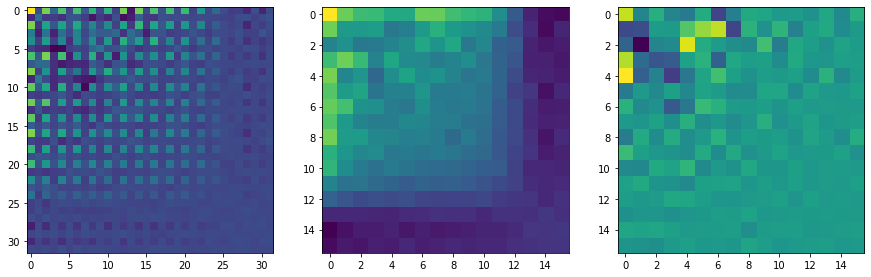

In [23]:
M_0 = M[::2,::2]
M_1 = M[1::2,1::2]
plt.figure(figsize=(15, 15)) 
plt.subplot(131); plt.imshow(M)
plt.subplot(132); plt.imshow(M_0)
plt.subplot(133); plt.imshow(M_1)
plt.show()

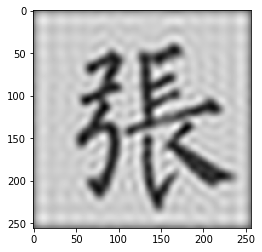

In [8]:
F_rec = np.dot(np.dot(Q.T,M),Q)
img_rec = F_rec.T
plt.imshow(img_rec,'gray')
plt.show()

### post-processing

阈值是: 13504.503216121468 
order是: 31


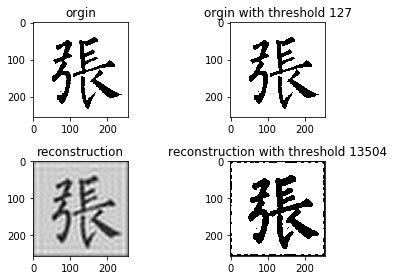

In [9]:
ret1, img_binary_rec = cv2.threshold(img_rec,np.mean(img_rec) ,1, cv2.THRESH_BINARY)
print("阈值是:", ret1, "\norder是:", n)
plt.subplot(221).set_title('orgin'); plt.imshow(img_gray,'gray_r')
plt.subplot(222).set_title('orgin with threshold 127'); plt.imshow(img_binary,'gray')
plt.subplot(223).set_title('reconstruction'); plt.imshow(img_rec,'gray')
plt.subplot(224).set_title('reconstruction with threshold %d' %ret1);plt.imshow(img_binary_rec,'gray')
# plt.subplot(224).set_title('reconstruction with threshold {0}'.format(ret1)); plt.imshow(img_binary_rec,'gray')
plt.tight_layout()
plt.show()


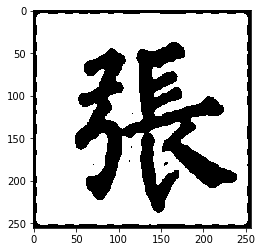

In [10]:
plt.imshow(img_binary_rec,'gray')
plt.show()

## Normalization operation (4.1)

In [11]:
def normalization_pq(p,q):
    # equation: u_pq += discrete_hermite(p,i,sigma) * discrete_hermite(q,j,sigma)
    u_pq = 0
#     method 1
    u_pq = np.sum(Q[p]) * np.sum(Q[q])
#     method 2
#     for i in range (k):
#         for j in range (k):
#             u_pq += Q[p,i] * Q[q,j] 
#     method 3 <-- not accurate: sum should be 0 when p is even, while not actually 
#     sum = 0
#     for i in range (Q.shape[1]):
#         sum+=Q[p,i]
    return u_pq

def normalization_denominator(i,j,U):
    denominator = 0
    for p in range(n+1):
        for q in range (n+1):
            # equation: denominator += normalization_pq(p,q) * discrete_hermite(p,i,sigma) * discrete_hermite(q,j,sigma)
            denominator += U[p,q] * Q[p,i] * Q[q,j] 
    return denominator
 

In [12]:
U = np.zeros((n+1,n+1), dtype = "double") 
for p in range(n+1):
    for q in range(n+1):
        U[p,q] = normalization_pq(p,q)

# method 1: using normalization_denominator function: integration by my own function <- slower
# denominator = np.zeros(img_rec.shape)
# for i in range (k):
#     for j in range (k):
#         denominator[i,j] = normalization_denominator(i,j,U)

# method 2 <- matrix multiplication
denominator = np.dot(np.dot(Q.T,U),Q)
# I_hat = I_tilde / denominator
img_nor_rec = img_rec / denominator

#### select binary_threshold after normalization

In [13]:
row, col = img.shape
black_pixel = int(row*col - img_binary.sum()) # the number of pixels == 0
flat = img_nor_rec.flatten()
flat.sort()
threshold = flat[black_pixel]
print(threshold)

0.4947580942732971


阈值是: 0.4947580942732971 
order是: 31


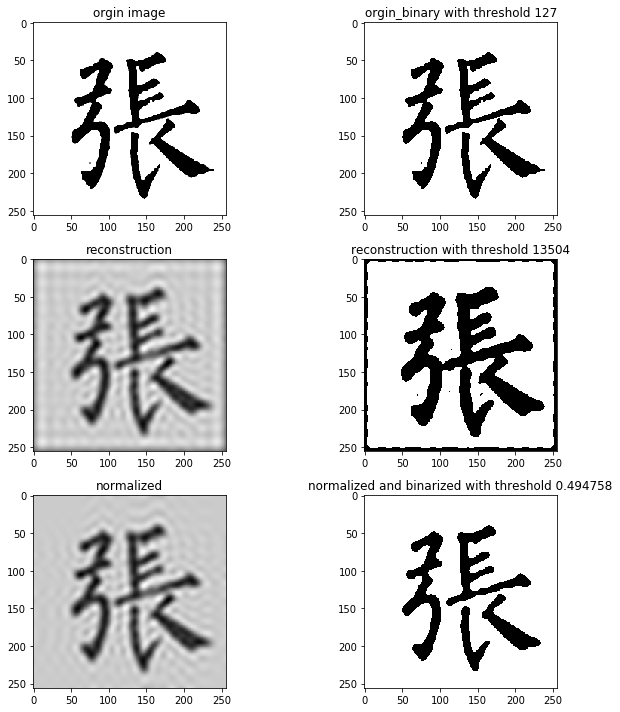

In [14]:
# method 1 <- not good
# threshold_coe = 0.8
# threshold_coe = (row*col - img_binary.sum()) / (row*col - img_binary_nor_rec.sum())
# print(threshold_coe)
# ret2, img_nor_binary_rec = cv2.threshold(img_rec_nor,np.mean(img_nor_rec) * threshold_coe ,1, cv2.THRESH_BINARY)
ret2, img_nor_binary_rec = cv2.threshold(img_nor_rec,threshold ,1, cv2.THRESH_BINARY)
print("阈值是:", ret2, "\norder是:", n)
plt.figure(figsize=(10, 10)) 
plt.subplot(321).set_title('orgin image'); plt.imshow(img_gray,'gray_r')
plt.subplot(322).set_title('orgin_binary with threshold 127'); plt.imshow(img_binary,'gray')
plt.subplot(323).set_title('reconstruction'); plt.imshow(img_rec,'gray')
plt.subplot(324).set_title('reconstruction with threshold %d' %ret1); plt.imshow(img_binary_rec,'gray')
plt.subplot(325).set_title('normalized'); plt.imshow(img_nor_rec,'gray') 
plt.subplot(326).set_title('normalized and binarized with threshold %f' %ret2); plt.imshow(img_nor_binary_rec,'gray')
# plt.subplot(334).set_title('reconstruction with threshold {0}'.format(ret1)); plt.imshow(img_binary_rec,'gray')
plt.tight_layout()
plt.show()

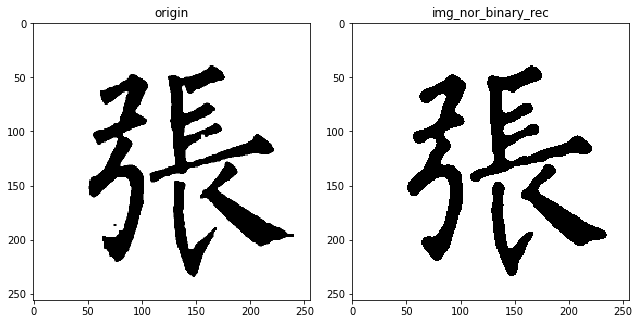

In [15]:
plt.figure(figsize=(9, 9))
plt.subplot(121).set_title("origin"); plt.imshow(img,"gray_r")
plt.subplot(122).set_title("img_nor_binary_rec"); plt.imshow(img_nor_binary_rec, 'gray')
plt.tight_layout()
plt.show()

## Recurrence Relation (Gaussian Bounded with Hermite Polynomial)

In [16]:
p=5
x=6
sigma = 2
a = sp.special.eval_hermite(p+1, x/sigma)*math.exp(-x**2/(2*sigma**2))
b = 2*(x/sigma)*sp.special.eval_hermite(p,x/sigma)*math.exp(-x**2/(2*sigma**2))-2*p*sp.special.eval_hermite(p-1,x/sigma)*math.exp(-x**2/(2*sigma**2))


In [17]:
print(a)
print(b)

157.03677506459337
157.03677506459346


In [18]:
p=5
x=6
sigma = 2
a = sp.special.eval_hermite(p+1, x)
a

2389704.000000002